In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import time
import gdown

In [ ]:
# Uber Fares Dataset NYC: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset/data

file_url = 'https://drive.google.com/file/d/1K-Y2coxz14gOVQrUKf_Q8HrMzw8VppI2/view?usp=sharing'
file_id = file_url.split('/')[-2]
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, output='downloaded_file', quiet=False)


In [ ]:
df = pd.read_csv('uber.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [ ]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [ ]:
df.dropna(subset=['dropoff_longitude'], inplace=True)

In [ ]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


# Travel distance & Duration
OSRM route service (http://project-osrm.org/docs/v5.5.1/api/#route-service)
- Local host is created after downloading related OSRM data for new york and utilizing Docker Desktop
1. download data (new-york-latest.osrm.pbf in this case) - https://download.geofabrik.de/
2. Initial extraction:
docker run -t -v "%cd%:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf
3. partitioning
docker run -t -v "%cd%:/data" osrm/osrm-backend osrm-partition -p /opt/car.lua /data/new-york-latest.osm
4. customization
docker run -t -v "%cd%:/data" osrm/osrm-backend osrm-customize -p /opt/car.lua /data/new-york-latest.osm
5. Activate Local host:
docker run -t -i -p 5000:5000 -v "%cd%:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm

Additional Considerations
API Documentation: Refer to the OSRM API Documentation for more details on available endpoints and query parameters.

Performance: Adjust server configurations (--algorithm, number of threads, etc.) in osrm-routed based on your application's requirements and server capabilities.

Data Updates: If OSM data gets updated or modified, you may need to re-run the extraction, partitioning, and customization steps to reflect the changes in the OSRM server.


In [ ]:
# Example coordinates (New York City)
start_point = "-73.984395,40.720077"
end_point = "-73.985508,40.768793"

# Construct OSRM request URL
osrm_url = f"http://localhost:5000/route/v1/driving/{start_point};{end_point}?overview=false"

# Send GET request to OSRM server
response = requests.get(osrm_url)

# Check if request was successful (status code 200)
if response.status_code == 200:
    route_data = response.json()
    print("Distance:", route_data['routes'][0]['distance'], "meters")
    print("Duration:", route_data['routes'][0]['duration'], "seconds")
else:
    print("Error fetching data:", response.status_code)

response.json()

Distance: 8643.6 meters
Duration: 780.5 seconds


{'code': 'Ok',
 'routes': [{'legs': [{'steps': [],
     'distance': 8643.6,
     'duration': 780.5,
     'summary': '',
     'weight': 780.5}],
   'distance': 8643.6,
   'duration': 780.5,
   'weight_name': 'routability',
   'weight': 780.5}],
 'waypoints': [{'hint': 'F84VgP___3-EAAAAjgAAAAYAAAAGAAAAxD3sQpHaCUEdLLRAHSy0QIQAAACOAAAABgAAAAYAAACoAwAA6xWX-_ZWbQJ1Fpf7zVZtAgEAXwGEORZH',
   'distance': 12.516528,
   'name': 'Clinton Street',
   'location': [-73.984533, 40.720118]},
  {'hint': 'c-kVgP___39DAAAAUAAAAHMAAAAQAAAA4lKVQgirXkHSDgBDxKqPQUMAAABQAAAAcwAAABAAAACoAwAA6xGX-9cUbgIcEpf7GRVuAgEAfweEORZH',
   'distance': 8.415994,
   'name': 'West 58th Street',
   'location': [-73.985557, 40.768727]}]}

In [ ]:
import requests
import time

#Function to get driving distance and duration


def get_driving_distance_and_duration(df):
    data = []
    base_url = "http://localhost:5000/route/v1/driving/"

    for index, row in df.iterrows():
        lat1 = row['Pickup_Latitude']
        lon1 = row['Pickup_Longitude']
        lat2 = row['Dropoff_Latitude']
        lon2 = row['Dropoff_Longitude']
        url = f"{base_url}{lon1},{lat1};{lon2},{lat2}?overview=false"

        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an error for bad responses

            item = response.json()
            if 'routes' in item and len(item['routes']) > 0:
                route = item['routes'][0]
                info = {
                    'Distance': route['distance'],
                    'Duration': route['duration']
                }
            else:
                info = {
                    'Distance': float('nan'),
                    'Duration': float('nan')
                }
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from OSRM API: {e}")
            info = {
                'Distance': float('nan'),
                'Duration': float('nan')
            }

        data.append(info)

    return pd.DataFrame(data)

<Axes: >

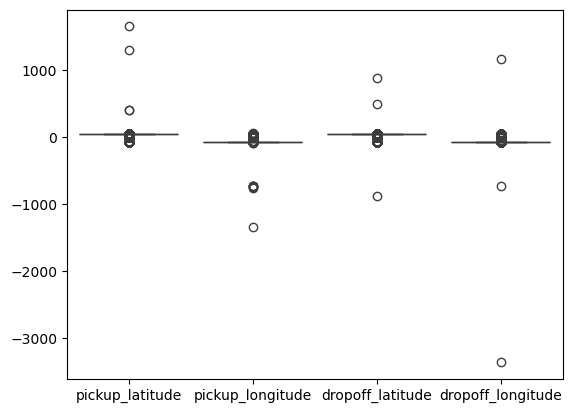

In [ ]:
sns.boxplot(data=df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

In [ ]:
# Filter the DataFrame based on coordinates
# Define the bounding box coordinates
min_latitude = 32.809227
max_latitude = 47.110989
min_longitude = -85.294933
max_longitude = -58.958312

df_filtered = df[
    (df['pickup_latitude'] >= min_latitude) & (df['pickup_latitude'] <= max_latitude) &
    (df['pickup_longitude'] >= min_longitude) & (df['pickup_longitude'] <= max_longitude) &
    (df['dropoff_latitude'] >= min_latitude) & (df['dropoff_latitude'] <= max_latitude) &
    (df['dropoff_longitude'] >= min_longitude) & (df['dropoff_longitude'] <= max_longitude)
]

<Axes: >

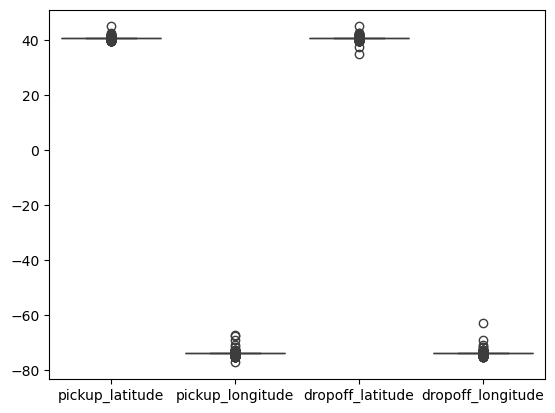

In [ ]:
sns.boxplot(data=df_filtered[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

In [ ]:
data = {
    'Pickup_Latitude': df_filtered['pickup_latitude'],
    'Pickup_Longitude': df_filtered['pickup_longitude'],
    'Dropoff_Latitude': df_filtered['dropoff_latitude'],
    'Dropoff_Longitude': df_filtered['dropoff_longitude']
}


df_coords = pd.DataFrame(data)
result_df = get_driving_distance_and_duration(df_coords)
result_df

Error fetching data from OSRM API: 400 Client Error: Bad Request for url: http://localhost:5000/route/v1/driving/-74.03588,40.724098;-74.035882,40.724103?overview=false
Error fetching data from OSRM API: 400 Client Error: Bad Request for url: http://localhost:5000/route/v1/driving/-74.028547,40.732684000000006;-74.028097,40.73281?overview=false
Error fetching data from OSRM API: 400 Client Error: Bad Request for url: http://localhost:5000/route/v1/driving/-73.78344,40.64867;-73.78341999999999,40.648704?overview=false
Error fetching data from OSRM API: 400 Client Error: Bad Request for url: http://localhost:5000/route/v1/driving/-74.030528,40.73842;-74.024978,40.73448?overview=false
Error fetching data from OSRM API: 400 Client Error: Bad Request for url: http://localhost:5000/route/v1/driving/-73.9558,40.77269;-71.7187,42.424147?overview=false
Error fetching data from OSRM API: 400 Client Error: Bad Request for url: http://localhost:5000/route/v1/driving/-74.032207,40.727518;-74.032225

,Distance,Duration
0,2097.9,282.8
1,3140.6,426.4
2,6586.7,804.0
3,2415.0,210.7
4,4995.0,437.0
...,...,...
195852,869.8,136.4
195853,2657.5,347.5
195854,15649.8,1328.2
195855,4023.5,421.9


In [ ]:
df_filtered = df_filtered.reset_index(drop=True)
df_filtered

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
195852,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
195853,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
195854,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
195855,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [ ]:
df_final = pd.concat([df_filtered, result_df], axis = 1)

In [ ]:
df_final

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,Duration
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,2097.9,282.8
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,3140.6,426.4
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,6586.7,804.0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,2415.0,210.7
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4995.0,437.0
...,...,...,...,...,...,...,...,...,...,...,...
195852,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,869.8,136.4
195853,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,2657.5,347.5
195854,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,15649.8,1328.2
195855,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,4023.5,421.9


In [ ]:
relative_path = r"C:\Users\salto\Documents\DataAnalytics\Module3.1-ML\week_project\data\uber_distance_dataset.csv"
df_final.to_csv(relative_path, index=False, sep=',', encoding='utf-8', header=True)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2868237552.py, line 1)